# Decision Tree with sklearn

In [334]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn import tree

from IPython.display import Image
import pandas as pd
import numpy as np
import pydotplus
import os

data = pd.read_csv('mushrooms.csv')

X = data.iloc[:,1:]
y = data['class']

le = preprocessing.LabelEncoder()

trans_data = []
for col in range(len(X.columns)):
    le.fit(X.iloc[:,col])
    transformed_data = le.transform(X.iloc[:,col]) 
    trans_data.append(transformed_data)

trans_data = np.array(trans_data)
trans_data = trans_data.transpose()
X = trans_data

le.fit(y)
target_data = le.transform(y) 
y = target_data

In [335]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7)

In [336]:
dt_clf = DecisionTreeClassifier()
dt_clf = dt_clf.fit(X_train, y_train)
dt_prediction = dt_clf.predict(X_test)

In [337]:
feature_names = data.columns.tolist()[1:]
target_names = ['edible','poison']

In [338]:
dt_dot_data = tree.export_graphviz(dt_clf, out_file = None,
                                  feature_names = feature_names,
                                  class_names = target_names,
                                  filled = True, rounded = True,
                                  special_characters = True)
dt_graph = pydotplus.graph_from_dot_data(dt_dot_data)
image = Image(dt_graph.create_png())

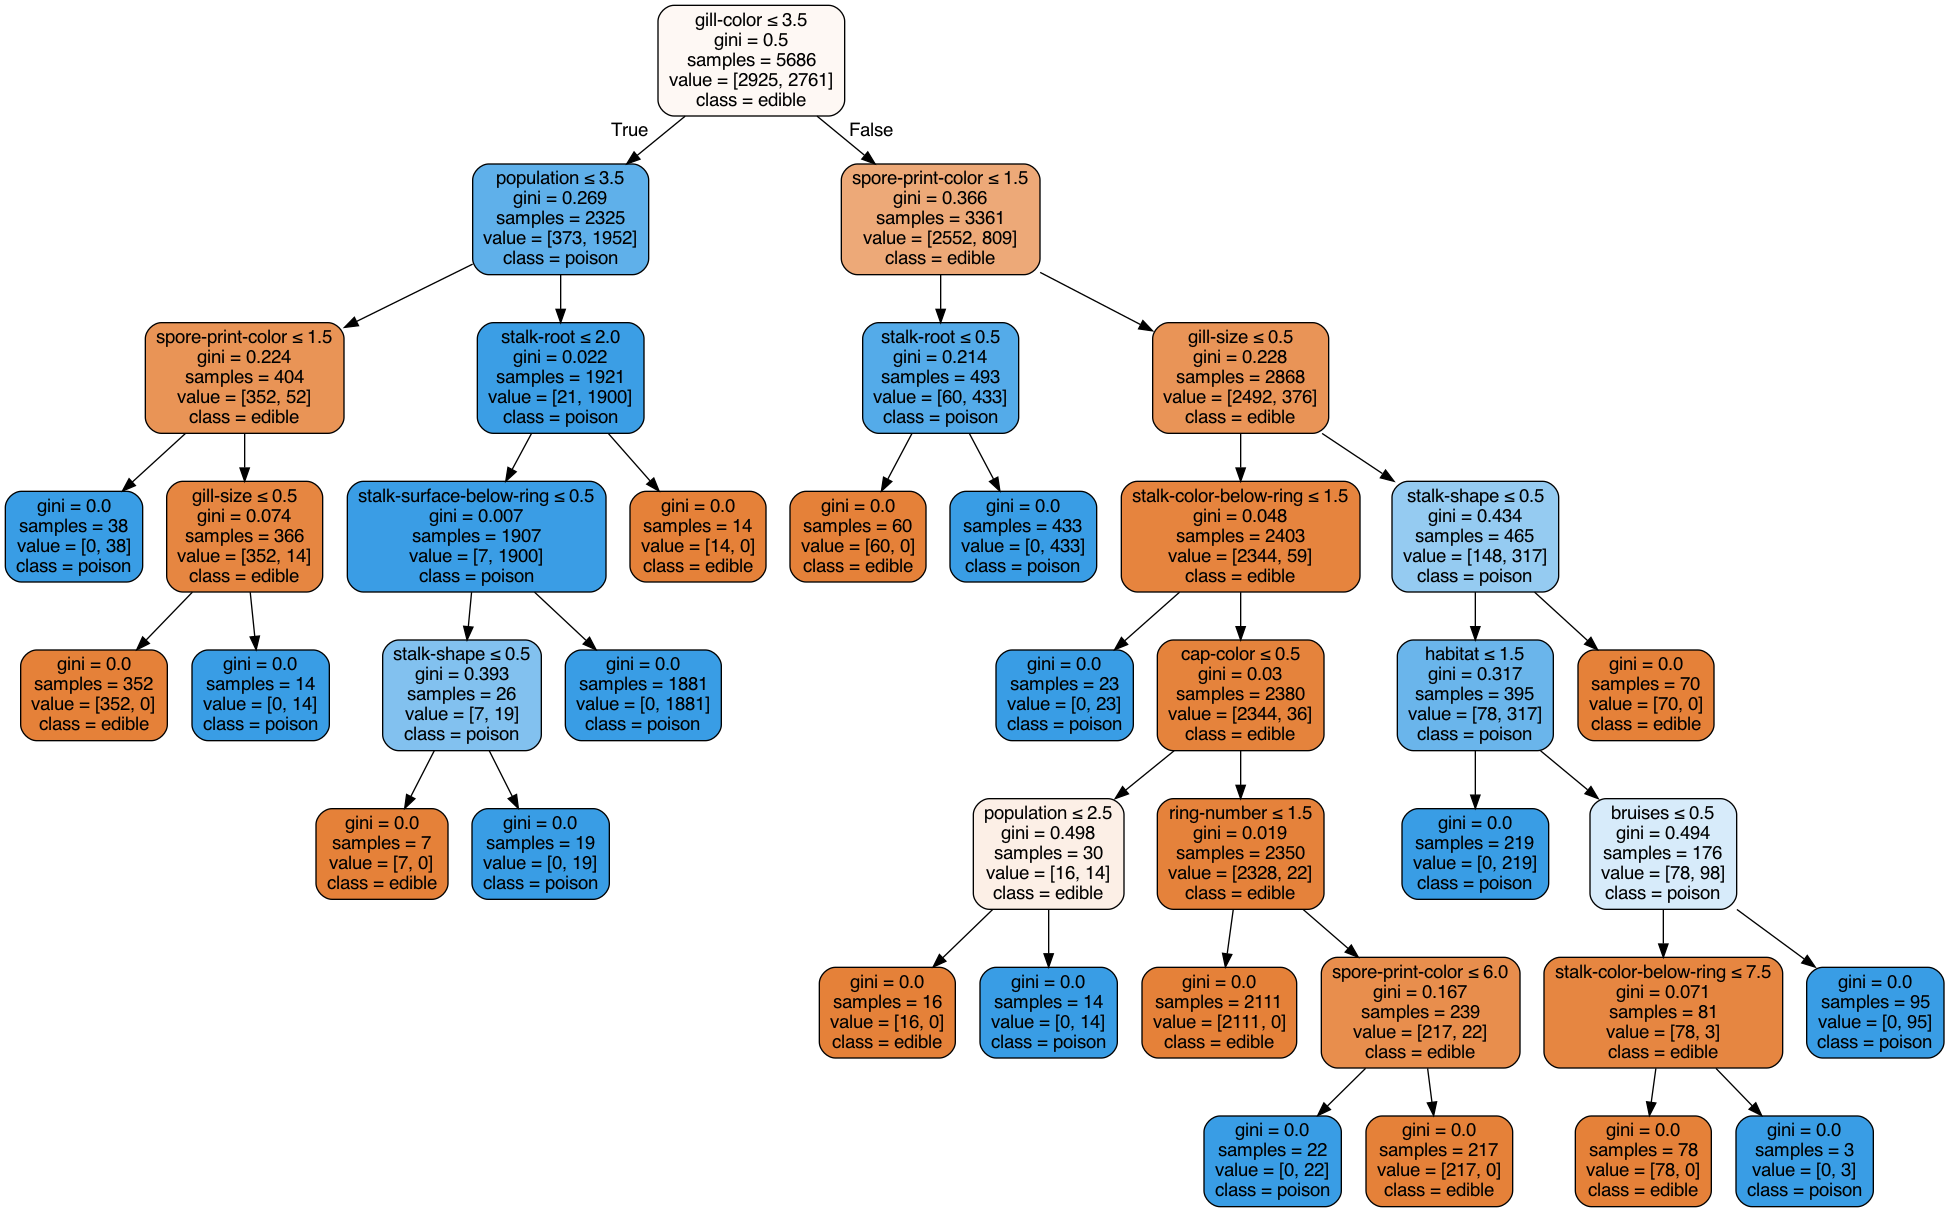

In [339]:
image

In [340]:
confusion_matrix(dt_prediction,y_test)

array([[1283,    0],
       [   0, 1155]])

In [341]:
dt_prediction

array([0, 0, 0, ..., 0, 0, 0])

In [342]:
y_test

array([0, 0, 0, ..., 0, 0, 0])

# My Decision tree

In [451]:
import pandas as pd
import numpy as np
import math 
import statistics 
import copy

from sklearn import preprocessing

data = pd.read_csv('mushrooms.csv')

X = data.iloc[:,1:]
y = data['class']

le = preprocessing.LabelEncoder()

trans_data = []
for col in range(len(X.columns)):
    le.fit(X.iloc[:,col])
    transformed_data = le.transform(X.iloc[:,col]) 
    trans_data.append(transformed_data)

trans_data = np.array(trans_data)
trans_data = trans_data.transpose()
X = trans_data
X = pd.DataFrame(X, columns=data.columns[1:])

le.fit(y)
target_data = le.transform(y) 
y = target_data

In [452]:
def calcul_info_gain(num_e, num_p):
    T = num_e + num_p
    e_prop = num_e/T
    p_prop = num_p/T
    
    return -e_prop*math.log2(e_prop) - p_prop*math.log2(p_prop) 

In [453]:
def get_attr_info(col):
    T = len(col)
    values = list(set(col))

    info = []
    for val in values:
        certain_row = [idx for idx,v in enumerate(col) if v == val]

        y_val = y[certain_row]
        num_y = len(y_val)
        num_e = len([v for v in y_val if v == 0])
        num_p = num_y - num_e

        if num_e == 0 or num_p == 0:
            i = 0
        else:
            i = calcul_info_gain(num_e, num_p)

        info.append((num_y, i))
        
    info_attr = 0
    for num, i in info:
        info_attr += (num/T)*i
    
    return info_attr

In [461]:
def get_important_col(X,y):
    origin_num_e = len([v for v in y if v == 0])
    origin_num_p = len(y) - origin_num_e

    expect_i = calcul_info_gain(origin_num_e, origin_num_p)
    
    gains = []
    for column in X.columns:
        gains.append(expect_i-get_attr_info(X[column]))
        
    max_att_idx = 0
    max_gain = 0
    
    for idx,gain in enumerate(gains):
        if max_gain < gain and len(set(X[X.columns[idx]])) > 1:
            max_gain = gain
            max_att_idx = idx
            
    return max_gain,max_att_idx

In [462]:
def branching(X,y,result=None, id=0):
    print(f'========={id}=========')
    print(len(X), len(y))
    print(result)
    if result == None:
        result = []
        
    if len(X.columns) == 0:
        return result
    
    num_poison = np.count_nonzero(y == 1) 
    print(num_poison/len(y) < 0.1 or num_poison/len(y))
    if num_poison/len(y) < 0.1 or num_poison/len(y) > 0.9:
        return result

    max_gain,max_att_idx = get_important_col(X,y)
    print(X.columns[max_att_idx])
    
    criteria = statistics.mean(set(X[X.columns[max_att_idx]]))
    print(set(X[X.columns[max_att_idx]]))
    
    col = X[X.columns[max_att_idx]]
    left = [idx for idx,v in enumerate(col) if criteria <= v]
    right = [idx for idx,v in enumerate(col) if criteria > v]

    left_X = X.loc[left,:].reset_index()
    left_X = left_X.iloc[:,1:]
    
    right_X = X.loc[right,:].reset_index()
    right_X = right_X.iloc[:,1:]

    left_y = y[left]
    right_y = y[right] 
    
    result.append((X.columns[max_att_idx], criteria))
    
    id += 1
    print()
    return branching(left_X,left_y,copy.copy(result),id), branching(right_X,right_y,copy.copy(result),id)

In [ ]:
branching(X,y,result=None)

=========0=========
8124 8124
None
0.48202855736090594
odor
{0, 1, 2, 3, 4, 5, 6, 7, 8}

=========1=========
4972 4972
[('odor', 4)]
0.3145615446500402
spore-print-color
{0, 1, 2, 3, 4, 5, 7, 8}

=========2=========
1980 1980
[('odor', 4), ('spore-print-color', 3.75)]
0.6606060606060606
stalk-color-below-ring
{1, 2, 4, 5, 6, 7, 8}

=========3=========
1768 1768
[('odor', 4), ('spore-print-color', 3.75), ('stalk-color-below-ring', 4.714285714285714)]
0.7104072398190046
spore-print-color
{8, 4, 5, 7}

=========4=========
1648 1648
[('odor', 4), ('spore-print-color', 3.75), ('stalk-color-below-ring', 4.714285714285714), ('spore-print-color', 6)]
0.7184466019417476
cap-color
{0, 1, 2, 3, 4, 5, 8, 9}

=========5=========
864 864
[('odor', 4), ('spore-print-color', 3.75), ('stalk-color-below-ring', 4.714285714285714), ('spore-print-color', 6), ('cap-color', 4)]
0.7037037037037037
gill-color
{0, 1, 2, 5, 6, 7, 10, 11}

=========6=========
200 200
[('odor', 4), ('spore-print-color', 3.75), ('s

=========30=========
9 9
[('odor', 4), ('spore-print-color', 3.75), ('stalk-color-below-ring', 4.714285714285714), ('spore-print-color', 6), ('cap-color', 4), ('gill-color', 5.25), ('habitat', 2.6), ('cap-surface', 1.5), ('cap-color', 7), ('stalk-surface-above-ring', 2), ('cap-shape', 2.5), ('cap-shape', 4), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3)]
0.1111111111111111
cap-shape
{3}

=========31=========
9 9
[('odor', 4), ('spore-print-color', 3.75), ('stalk-color-below-ring', 4.714285714285714), ('spore-print-color', 6), ('cap-color', 4), ('gill-color', 5.25), ('habitat', 2.6), ('cap-surface', 1.5), ('cap-color', 7), ('stalk-surface-above-ring', 2), ('cap-shape', 2.5), ('cap-shape', 4), ('cap-shape', 3), ('ca

cap-shape
{3}

=========52=========
9 9
[('odor', 4), ('spore-print-color', 3.75), ('stalk-color-below-ring', 4.714285714285714), ('spore-print-color', 6), ('cap-color', 4), ('gill-color', 5.25), ('habitat', 2.6), ('cap-surface', 1.5), ('cap-color', 7), ('stalk-surface-above-ring', 2), ('cap-shape', 2.5), ('cap-shape', 4), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-sha

cap-shape
{3}

=========71=========
9 9
[('odor', 4), ('spore-print-color', 3.75), ('stalk-color-below-ring', 4.714285714285714), ('spore-print-color', 6), ('cap-color', 4), ('gill-color', 5.25), ('habitat', 2.6), ('cap-surface', 1.5), ('cap-color', 7), ('stalk-surface-above-ring', 2), ('cap-shape', 2.5), ('cap-shape', 4), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-sha

=========89=========
9 9
[('odor', 4), ('spore-print-color', 3.75), ('stalk-color-below-ring', 4.714285714285714), ('spore-print-color', 6), ('cap-color', 4), ('gill-color', 5.25), ('habitat', 2.6), ('cap-surface', 1.5), ('cap-color', 7), ('stalk-surface-above-ring', 2), ('cap-shape', 2.5), ('cap-shape', 4), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-

=========106=========
9 9
[('odor', 4), ('spore-print-color', 3.75), ('stalk-color-below-ring', 4.714285714285714), ('spore-print-color', 6), ('cap-color', 4), ('gill-color', 5.25), ('habitat', 2.6), ('cap-surface', 1.5), ('cap-color', 7), ('stalk-surface-above-ring', 2), ('cap-shape', 2.5), ('cap-shape', 4), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap

cap-shape
{3}

=========123=========
9 9
[('odor', 4), ('spore-print-color', 3.75), ('stalk-color-below-ring', 4.714285714285714), ('spore-print-color', 6), ('cap-color', 4), ('gill-color', 5.25), ('habitat', 2.6), ('cap-surface', 1.5), ('cap-color', 7), ('stalk-surface-above-ring', 2), ('cap-shape', 2.5), ('cap-shape', 4), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-sh

=========136=========
9 9
[('odor', 4), ('spore-print-color', 3.75), ('stalk-color-below-ring', 4.714285714285714), ('spore-print-color', 6), ('cap-color', 4), ('gill-color', 5.25), ('habitat', 2.6), ('cap-surface', 1.5), ('cap-color', 7), ('stalk-surface-above-ring', 2), ('cap-shape', 2.5), ('cap-shape', 4), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap

cap-shape
{3}

=========156=========
9 9
[('odor', 4), ('spore-print-color', 3.75), ('stalk-color-below-ring', 4.714285714285714), ('spore-print-color', 6), ('cap-color', 4), ('gill-color', 5.25), ('habitat', 2.6), ('cap-surface', 1.5), ('cap-color', 7), ('stalk-surface-above-ring', 2), ('cap-shape', 2.5), ('cap-shape', 4), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-sh


=========173=========
9 9
[('odor', 4), ('spore-print-color', 3.75), ('stalk-color-below-ring', 4.714285714285714), ('spore-print-color', 6), ('cap-color', 4), ('gill-color', 5.25), ('habitat', 2.6), ('cap-surface', 1.5), ('cap-color', 7), ('stalk-surface-above-ring', 2), ('cap-shape', 2.5), ('cap-shape', 4), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('ca

=========195=========
9 9
[('odor', 4), ('spore-print-color', 3.75), ('stalk-color-below-ring', 4.714285714285714), ('spore-print-color', 6), ('cap-color', 4), ('gill-color', 5.25), ('habitat', 2.6), ('cap-surface', 1.5), ('cap-color', 7), ('stalk-surface-above-ring', 2), ('cap-shape', 2.5), ('cap-shape', 4), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap

cap-shape
{3}

=========217=========
9 9
[('odor', 4), ('spore-print-color', 3.75), ('stalk-color-below-ring', 4.714285714285714), ('spore-print-color', 6), ('cap-color', 4), ('gill-color', 5.25), ('habitat', 2.6), ('cap-surface', 1.5), ('cap-color', 7), ('stalk-surface-above-ring', 2), ('cap-shape', 2.5), ('cap-shape', 4), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-sh

cap-shape
{3}

=========246=========
9 9
[('odor', 4), ('spore-print-color', 3.75), ('stalk-color-below-ring', 4.714285714285714), ('spore-print-color', 6), ('cap-color', 4), ('gill-color', 5.25), ('habitat', 2.6), ('cap-surface', 1.5), ('cap-color', 7), ('stalk-surface-above-ring', 2), ('cap-shape', 2.5), ('cap-shape', 4), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-sh

=========270=========
9 9
[('odor', 4), ('spore-print-color', 3.75), ('stalk-color-below-ring', 4.714285714285714), ('spore-print-color', 6), ('cap-color', 4), ('gill-color', 5.25), ('habitat', 2.6), ('cap-surface', 1.5), ('cap-color', 7), ('stalk-surface-above-ring', 2), ('cap-shape', 2.5), ('cap-shape', 4), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap

=========286=========
9 9
[('odor', 4), ('spore-print-color', 3.75), ('stalk-color-below-ring', 4.714285714285714), ('spore-print-color', 6), ('cap-color', 4), ('gill-color', 5.25), ('habitat', 2.6), ('cap-surface', 1.5), ('cap-color', 7), ('stalk-surface-above-ring', 2), ('cap-shape', 2.5), ('cap-shape', 4), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap

=========313=========
9 9
[('odor', 4), ('spore-print-color', 3.75), ('stalk-color-below-ring', 4.714285714285714), ('spore-print-color', 6), ('cap-color', 4), ('gill-color', 5.25), ('habitat', 2.6), ('cap-surface', 1.5), ('cap-color', 7), ('stalk-surface-above-ring', 2), ('cap-shape', 2.5), ('cap-shape', 4), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap

cap-shape
{3}

=========331=========
9 9
[('odor', 4), ('spore-print-color', 3.75), ('stalk-color-below-ring', 4.714285714285714), ('spore-print-color', 6), ('cap-color', 4), ('gill-color', 5.25), ('habitat', 2.6), ('cap-surface', 1.5), ('cap-color', 7), ('stalk-surface-above-ring', 2), ('cap-shape', 2.5), ('cap-shape', 4), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-sh

=========356=========
9 9
[('odor', 4), ('spore-print-color', 3.75), ('stalk-color-below-ring', 4.714285714285714), ('spore-print-color', 6), ('cap-color', 4), ('gill-color', 5.25), ('habitat', 2.6), ('cap-surface', 1.5), ('cap-color', 7), ('stalk-surface-above-ring', 2), ('cap-shape', 2.5), ('cap-shape', 4), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap

=========375=========
9 9
[('odor', 4), ('spore-print-color', 3.75), ('stalk-color-below-ring', 4.714285714285714), ('spore-print-color', 6), ('cap-color', 4), ('gill-color', 5.25), ('habitat', 2.6), ('cap-surface', 1.5), ('cap-color', 7), ('stalk-surface-above-ring', 2), ('cap-shape', 2.5), ('cap-shape', 4), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap

=========395=========
9 9
[('odor', 4), ('spore-print-color', 3.75), ('stalk-color-below-ring', 4.714285714285714), ('spore-print-color', 6), ('cap-color', 4), ('gill-color', 5.25), ('habitat', 2.6), ('cap-surface', 1.5), ('cap-color', 7), ('stalk-surface-above-ring', 2), ('cap-shape', 2.5), ('cap-shape', 4), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap

=========419=========
9 9
[('odor', 4), ('spore-print-color', 3.75), ('stalk-color-below-ring', 4.714285714285714), ('spore-print-color', 6), ('cap-color', 4), ('gill-color', 5.25), ('habitat', 2.6), ('cap-surface', 1.5), ('cap-color', 7), ('stalk-surface-above-ring', 2), ('cap-shape', 2.5), ('cap-shape', 4), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap

cap-shape
{3}

=========446=========
9 9
[('odor', 4), ('spore-print-color', 3.75), ('stalk-color-below-ring', 4.714285714285714), ('spore-print-color', 6), ('cap-color', 4), ('gill-color', 5.25), ('habitat', 2.6), ('cap-surface', 1.5), ('cap-color', 7), ('stalk-surface-above-ring', 2), ('cap-shape', 2.5), ('cap-shape', 4), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-sh

cap-shape
{3}

=========466=========
9 9
[('odor', 4), ('spore-print-color', 3.75), ('stalk-color-below-ring', 4.714285714285714), ('spore-print-color', 6), ('cap-color', 4), ('gill-color', 5.25), ('habitat', 2.6), ('cap-surface', 1.5), ('cap-color', 7), ('stalk-surface-above-ring', 2), ('cap-shape', 2.5), ('cap-shape', 4), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-sh

cap-shape
{3}

=========472=========
9 9
[('odor', 4), ('spore-print-color', 3.75), ('stalk-color-below-ring', 4.714285714285714), ('spore-print-color', 6), ('cap-color', 4), ('gill-color', 5.25), ('habitat', 2.6), ('cap-surface', 1.5), ('cap-color', 7), ('stalk-surface-above-ring', 2), ('cap-shape', 2.5), ('cap-shape', 4), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-sh

=========491=========
9 9
[('odor', 4), ('spore-print-color', 3.75), ('stalk-color-below-ring', 4.714285714285714), ('spore-print-color', 6), ('cap-color', 4), ('gill-color', 5.25), ('habitat', 2.6), ('cap-surface', 1.5), ('cap-color', 7), ('stalk-surface-above-ring', 2), ('cap-shape', 2.5), ('cap-shape', 4), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap

9 9
[('odor', 4), ('spore-print-color', 3.75), ('stalk-color-below-ring', 4.714285714285714), ('spore-print-color', 6), ('cap-color', 4), ('gill-color', 5.25), ('habitat', 2.6), ('cap-surface', 1.5), ('cap-color', 7), ('stalk-surface-above-ring', 2), ('cap-shape', 2.5), ('cap-shape', 4), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-sha

=========524=========
9 9
[('odor', 4), ('spore-print-color', 3.75), ('stalk-color-below-ring', 4.714285714285714), ('spore-print-color', 6), ('cap-color', 4), ('gill-color', 5.25), ('habitat', 2.6), ('cap-surface', 1.5), ('cap-color', 7), ('stalk-surface-above-ring', 2), ('cap-shape', 2.5), ('cap-shape', 4), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap

cap-shape
{3}

=========542=========
9 9
[('odor', 4), ('spore-print-color', 3.75), ('stalk-color-below-ring', 4.714285714285714), ('spore-print-color', 6), ('cap-color', 4), ('gill-color', 5.25), ('habitat', 2.6), ('cap-surface', 1.5), ('cap-color', 7), ('stalk-surface-above-ring', 2), ('cap-shape', 2.5), ('cap-shape', 4), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-sh


=========561=========
9 9
[('odor', 4), ('spore-print-color', 3.75), ('stalk-color-below-ring', 4.714285714285714), ('spore-print-color', 6), ('cap-color', 4), ('gill-color', 5.25), ('habitat', 2.6), ('cap-surface', 1.5), ('cap-color', 7), ('stalk-surface-above-ring', 2), ('cap-shape', 2.5), ('cap-shape', 4), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('ca

cap-shape
{3}

=========584=========
9 9
[('odor', 4), ('spore-print-color', 3.75), ('stalk-color-below-ring', 4.714285714285714), ('spore-print-color', 6), ('cap-color', 4), ('gill-color', 5.25), ('habitat', 2.6), ('cap-surface', 1.5), ('cap-color', 7), ('stalk-surface-above-ring', 2), ('cap-shape', 2.5), ('cap-shape', 4), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-shape', 3), ('cap-sh

In [376]:
get_important_col(left_X,left_y)

(0.8926676769273187, 0)

In [377]:
get_important_col(right_X,right_y)

(0.8127662159352227, 0)

In [378]:
a = None

In [379]:
a == None

True

In [385]:
np.count_nonzero(y == 1)

3916

In [386]:
len(y)

8124

In [387]:
y

array([1, 0, 0, ..., 0, 1, 0])

In [389]:
data

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,e,k,s,n,f,n,a,c,b,y,...,s,o,o,p,o,o,p,b,c,l
8120,e,x,s,n,f,n,a,c,b,y,...,s,o,o,p,n,o,p,b,v,l
8121,e,f,s,n,f,n,a,c,b,n,...,s,o,o,p,o,o,p,b,c,l
8122,p,k,y,n,f,y,f,c,n,b,...,k,w,w,p,w,o,e,w,v,l


In [423]:
X

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,5,2,4,1,6,1,0,1,4,0,...,2,7,7,0,2,1,4,2,3,5
1,5,2,9,1,0,1,0,0,4,0,...,2,7,7,0,2,1,4,3,2,1
2,0,2,8,1,3,1,0,0,5,0,...,2,7,7,0,2,1,4,3,2,3
3,5,3,8,1,6,1,0,1,5,0,...,2,7,7,0,2,1,4,2,3,5
4,5,2,3,0,5,1,1,0,4,1,...,2,7,7,0,2,1,0,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,3,2,4,0,5,0,0,0,11,0,...,2,5,5,0,1,1,4,0,1,2
8120,5,2,4,0,5,0,0,0,11,0,...,2,5,5,0,0,1,4,0,4,2
8121,2,2,4,0,5,0,0,0,5,0,...,2,5,5,0,1,1,4,0,1,2
8122,3,3,4,0,8,1,0,1,0,1,...,1,7,7,0,2,1,0,7,4,2


In [408]:
X.reset_index()

,index,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,0,5,2,4,1,6,1,0,1,4,...,2,7,7,0,2,1,4,2,3,5
1,1,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
2,2,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
3,3,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
4,4,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,8119,3,2,4,0,5,0,0,0,11,...,2,5,5,0,1,1,4,0,1,2
8120,8120,5,2,4,0,5,0,0,0,11,...,2,5,5,0,0,1,4,0,4,2
8121,8121,2,2,4,0,5,0,0,0,5,...,2,5,5,0,1,1,4,0,1,2
8122,8122,3,3,4,0,8,1,0,1,0,...,1,7,7,0,2,1,0,7,4,2


In [432]:
test_X = X.loc[[3,9,12],:].reset_index()

In [433]:
test_X

,index,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,3,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
1,9,0,2,9,1,0,1,0,0,2,...,2,7,7,0,2,1,4,2,3,3
2,12,0,2,9,1,0,1,0,0,10,...,2,7,7,0,2,1,4,3,3,1


,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,5,3,8,1,6,1,0,1,5,0,...,2,7,7,0,2,1,4,2,3,5
1,0,2,9,1,0,1,0,0,2,0,...,2,7,7,0,2,1,4,2,3,3
2,0,2,9,1,0,1,0,0,10,0,...,2,7,7,0,2,1,4,3,3,1


In [445]:
set(X[X.columns[max_att_idx]])

AttributeError: 'set' object has no attribute 'mean'

In [447]:
statistics.mean(set(X[X.columns[max_att_idx]]))

4

In [448]:
set(X[X.columns[max_att_idx]])

{0, 1, 2, 3, 4, 5, 6, 7, 8}